In [1]:
import numpy as np
import random
import math
import copy
import matplotlib.pyplot as plt

In [2]:
def get_points(n,stride,mmax,mmin):
    tem=list(range(0,n,stride))
    points=np.random.rand(len(tem))
    points=points*(mmax-mmin)
    points+=mmin
    nums=np.array(tem)
    points=np.vstack((nums,points)).T
    return points

In [3]:
symbol=['sin','cos','+','-','*','/','num','x']
symbol=dict(zip(range(len(symbol)),symbol))

In [4]:
class node:
    def __init__(self):
        self.value=0
        self.lchild=0
        self.rchild=0
        
    def compute(self,x):#计算适应度
        if self.lchild==0:
            if self.value=='x':
                return x
            else:
                #print(self.value)
                return self.value
        else:
            a=self.lchild.compute(x)
            if self.value=='sin':
                return math.sin(a)
            elif self.value=='cos':
                return math.cos(a)
            elif self.value=='+':
                return a+self.rchild.compute(x)
            elif self.value=='-':
                return a-self.rchild.compute(x)
            elif self.value=='*':
                return a*self.rchild.compute(x)
            elif self.value=='/':
                b=self.rchild.compute(x)
                if b>=0:
                    b=max([0.001,b])
                else:
                    b=min([-0.001,b])
                return a/b
            #elif self.value=='^':
            #    return a**self.rchild.compute(x)
            
    def mutations_tool(self,pm,d=0):#对单个node以pm概率变异
        if random.random()<pm:
            v=symbol[int(random.random()*len(symbol))]
            if v=='num':
                self.value=random.random()*100
            else:
                self.value=v
            if v=='num' or v=='x':
                self.lchild=0
                self.rchild=0
            elif v=='sin' or v=='cos':
                if self.lchild==0:
                    self.lchild=node()
                    self.lchild.randini(d+1)
                self.rchild=0
            else:
                if self.lchild==0:
                    self.lchild=node()
                    self.lchild.randini(d+1)
                if self.rchild==0:
                    self.rchild=node()
                    self.rchild.randini(d+1)
        if self.lchild!=0 and d<=4:
            self.lchild.mutations_tool(pm,d+1)
        if self.rchild!=0 and d<=4:
            self.rchild.mutations_tool(pm,d+1)
        return
    
    def randini(self,d=0,dmax=4):#随机初始化
        if d>=dmax:
            if random.random()>0.5:
                self.value=random.random()*100
                #print(self.value,d)
                return
            else:
                self.value='x'
                #print(self.value,d)
                return
        v=symbol[int(random.random()*len(symbol))]
        #print(v,d)
        if v!='num' and v!='x':
            self.value=v
            self.lchild=node()
            self.lchild.randini(d+1,dmax)
            if v!='sin' and v!='cos':
                self.rchild=node()
                self.rchild.randini(d+1,dmax)
        elif v=='num':
            self.value=random.random()*100
        else:
            self.value='x'
        return
    
    def show(self,d=0):#深度优先显示二叉树
        print(self.value,d)
        if self.lchild!=0:
            self.lchild.show(d+1)
        if self.rchild!=0:
            self.rchild.show(d+1)
        return
    
    def istermin(self):
        if self.lchild==0 and self.rchild==0:
            return True
        else:
            return False

In [5]:
func=[]
for i in range(50):
    fun=node()
    fun.randini()
    func.append(fun)
points=get_points(100,4,100,0)

In [6]:
class GP:
    def __init__(self,n,points,funclist,pm,pc):
        self.n=n
        self.points=points
        self.func=funclist
        self.v=[0]*n
        self.pm=pm
        self.pc=pc
    
    def compute(self):#对种群计算适应度
        for a in range(self.n):
            i=self.func[a]
            v=0
            for j in self.points:
                error=(i.compute(j[0])-j[1])**2
                v+=error
            v/=self.points.shape[0]
            self.v[a]=min([v,1e10])
        return
    
    def choose(self,mode=True,q=0.5):#选择
        '''mode为True是按比例的适应度分配，False是基于排序的适应度分配,q为当mode为False时第一位概率'''
        p=np.zeros(self.n)
        if mode:
            m=max(self.v)
            self.v=[i-m for i in self.v]
            self.v=[abs(i)+1 for i in self.v]
            sum_p=np.sum(self.v)
            self.v=self.v/sum_p
        else:
            p1=q
            for _ in range(self.n):
                num=np.argmin(self.v)
                p[num]=p1
                self.v[num]=1e10
                p1=p1*(1-q)
            self.v=p
            self.v[np.argmin(self.v)]+=1-np.sum(self.v)
        #print(self.v)
        list_s=np.random.choice(self.n,self.n,p=self.v)
        s1=[]
        print(list_s)
        for i in range(self.n):
            tem=copy.deepcopy(self.func[list_s[i]])
            s1.append(tem)
        self.func=s1
        return
    
    def cross(self):
        f=[]
        for a in self.func:
            if random.random()<self.pc:
                mark=True
                m = np.random.randint(0, self.n, size=1)[0]
                b = self.func[m]
                if a.istermin():
                    a=b
                    mark=False
                elif b.istermin():
                    mark=False
                while mark:
                    c=np.random.choice(4,p=np.array([0.4,0.1,0.4,0.1]))
                    if c==0:
                        a1=a.lchild
                        b1=b.lchild
                        if a1.istermin() or b1.istermin():
                            a.lchild=b.lchild
                            break
                        else:
                            a=a1
                            b=b1
                    elif c==1:
                        a.lchild=b.lchild
                        break
                    elif c==2:
                        if a.rchild!=0 and b.rchild!=0:
                            a1=a.rchild
                            b1=b.rchild
                            if a1.istermin() or b1.istermin():
                                a.rchild=b.rchild
                                break
                            else:
                                a=a1
                                b=b1
                        else:
                            a=b
                            break
                    elif c==3:
                        if a.rchild!=0 and b.rchild!=0:
                            a.rchild=b.rchild
                            break
                        else:
                            a=b
                            break
            f.append(a)
        self.func=f
        return
    
    def mutations(self):#变异
        f=[]
        for i in self.func:
            i.mutations_tool(self.pm)
            f.append(i)
        self.func=f
        return
    
    def train(self):
        self.compute()
        sequence=0
        r=[]
        n=0
        m=1e10
        while n<150:
            self.choose(True)
            if random.random()<0.5:
                self.cross()
            else:
                self.mutations()
            self.compute()
            m1=min(self.v)
            if m>m1:
                tem=self.func[np.argmin(self.v)]
                #print(tem)
                sequence=copy.deepcopy(tem)
            m=min(m1,m)
            r.append(m)
            n+=1
        return m,r,sequence

In [7]:
agent=GP(50,points,func,0.01,0.9)

In [8]:
result=agent.train()

[10 18 46 28 43 36 44 44 43  5 15 45 27 34  3  5 39  1 13 23 11 45 25 16
 36 14  2 12 14 48 37 17 16 44 27 25 42 11 39  1 23 25 38 17 30  8 46 30
  9 13]
[ 8 32  9 32 15 24 25  4  7 21 48 49 25 31  6 49  8 47 40 26  1  9  3  8
 18 46 49 33 19 10 34 47  7  9  3  4  0 20 32 40 47  2  2 47 13 29 38 45
 49 28]
[36 22 31 48 26  1 37 49 23 16 38 15 14 40 27 16 30  8 20  1 34 30 28 18
 26  8  9 46 38 27 24 40 38  7 28  7  8 30  6 15 16 43 22 45 47 27 38 35
 48 23]
[10  3  7 10 18 11  8 12 15 42  1 39 34 47 25 40 49 15 41 16 14 24  1 18
 39 34  0 21 31 31 34 25  5 12 16 10 45 34 22 12 28 27 12 46 35  8 47 14
 15 27]
[19 34  9  6 20 43 40 37 31 40 44 40 43 49 48 29 15  5 47 32 43 49  7  8
 10  5  9 26  6 20 11 21 42 19 16 14  4 28 41 40 33 31 11 38 38 21 28 43
 33 48]
[35  5 45 30  0 14 25  1 41 21  3 26 33  5 32 13 40  1  3 14 29 44 26 32
 39  5 44 12 13 37 35 47 37 37  6  9 30 34  5 13 29 42  7  0 12 39 42 37
 25  9]
[10 37 43 12 21 46  7 37 35 25 15 28  9 29  6 38 25 46 34 30 19 38  4  3
 34

[43 48 11 18 26 15 45 35 18 38 12 35 17  0 10 46  7 28 35 17  0  9  4 19
 43  0 15 26  1 44 12 46  1 35  9 46 38 47 47 47  7 46 25 46 15 17 15 19
 46 35]
[ 1 20 39 30 44 16 43 34 36 25 35 26 26  8  4  3 35 27  3 26 22 14 16 32
  8 28 27  5 27  2 21 29 43 38 41 49 39 12 31  7 30 22 25 33 19 25 17  2
 30 49]
[22 29 14 48 29  0 36 35 15 22 30 34 39  4 24 20 46 15 32 31 36  4 17  3
 32 49 14 33 21 49  3 48 49  8 20 40  2 27  3 17 31  2 21 20 21 20 15 34
  9 25]
[36 18 49 18 16 24 16 17 31  8 11 15 34 16 15 42 31 19 31 28 26  4 40 23
 11 21 16 28 41 31 16 25  6 23  6 25 18  6 11 20 49  1 30 34 44 38 42 29
 32 25]
[ 1 47 12 48 23 25 43 41 48 46 27 22 22 23 40 25 18  1 41 27 29 25  5 46
 11 22 44 48 17 16  2 11 41 49 24 48 24 38 20 15  8 42 48 38 23  5 43  0
  2 28]
[22 49 14  6 46 13 13 20 36 18 17 24 45 36  8 36 14  8 27 12 35 34 39 25
 43 13 17 43 20  4 31 44 30  3 29 44  0 49 29 17 42 34 29 34 13  9 36 20
 46 31]
[15 37  3  3 21 17 15 41 35 33  7 47 35 34  6 17 18 49 27 35 19 17 36 17
 35

[16 26  8 28 29 17 40 21 12 46 45  3  3 33 18 20 39  6  4 27  8 17 32  6
 12 29 32 16 38 22  8 12 16 20 39 10 31 26 10  2 25 48 27 45 26  3 22  6
  4 16]
[17 17 17 24 42 12 40  8 18  9 47 39  9 46 17  9 47 26 18  8  9 32 23 26
 23 40 22 15 28 20 23  9  8 44  9 14 37 12  5 12 44 18  8 37 44 47 26 15
 24 37]
[38 39  5 19 23 43 43  8  5 46 34  5  7 26 31 32 44 31 11 35  7 13 37 27
  5 31  7 47 10 35  5 20 15 39 31 11 35 43 15 38 15 31 25 31 10 40 39  8
 19  8]
[30 34 27 24 36  5 39  1 15 23 22 30 19  7 28 19 34 31 34 17 34 24 15 20
 30 13 39 25  5 31 39 19 25 27 45 11  5 31  1 20 35 40 27 35 13 24  6  6
 28  2]
[ 6 35  4 42 37 39 46 29 32 29  3 30 41 49  3  0  6  2 36 40 46 15 34 31
 42 29 20 23 44 30 48  7 41 21 45 36 49 23 24 31 20 49  8 34  5 26 18  2
 34 22]
[17  1  6 24 42 13  2 31 40 37 37 10 24 37 30 24 16 40 13 29  6 17 33 36
  0 33 42  2 43 16  1 43 36 29 45 13  5 11 30 37 43  2  9  5 17 12 16 13
  3 11]
[18 20 36 27 13 36  3 23 29 45 48 48  2 12 43  5 32  9 12 43  2 18 10 42
  0

[9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02 9.14806793e+02 9.14806793e+02
 9.14806793e+02 1.69699191e+06 9.14806793e+02 9.14806793e+02
 9.14806793e+02 9.14806793e+02]
/ 0
+ 1
- 2
/ 3
x 4
86.57316130944876 4
* 3
54.68945307411241 4
x 4
cos 2
/ 3
x 4
x 4
- 1
cos 2
x 3
x 2


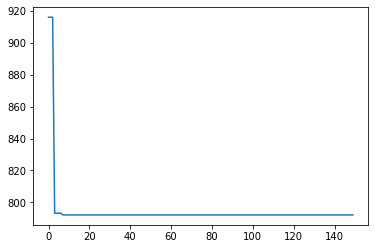

In [9]:
print(agent.v)
if result[2]!=0:
    result[2].show()
fig, ax=plt.subplots(1, 1)
ax.clear()
ax.plot(result[1])
fig.canvas.draw()

In [10]:
result[0]/25

38.11561941229643

In [14]:
points

array([[ 0.        , 54.69319151],
       [ 4.        , 93.85936301],
       [ 8.        , 42.59824135],
       [12.        , 85.87991425],
       [16.        , 30.97573755],
       [20.        , 93.84627068],
       [24.        , 13.6047302 ],
       [28.        , 33.94632074],
       [32.        , 74.77539102],
       [36.        , 31.6807887 ],
       [40.        ,  6.74752221],
       [44.        , 55.15268563],
       [48.        , 25.09083061],
       [52.        , 25.79077491],
       [56.        , 52.78475667],
       [60.        , 28.94082312],
       [64.        , 52.62556949],
       [68.        , 95.09664845],
       [72.        , 63.96502614],
       [76.        ,  0.52370874],
       [80.        , 47.75483155],
       [84.        , 91.68431243],
       [88.        , 39.04375685],
       [92.        , 63.66127407],
       [96.        , 41.34033746]])